<a href="https://colab.research.google.com/github/Sazim2019331087/voice_model/blob/main/CNN_RNN_Model%20Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("--- Installing required libraries ---")
!pip install --upgrade pip
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 # Install PyTorch with CUDA support
!pip install pandas scikit-learn joblib tqdm # tqdm for progress bars
!pip install ffmpeg-python # Python wrapper for ffmpeg
!apt-get update && apt-get install -y ffmpeg # Install ffmpeg on Colab for audio processing

--- Installing required libraries ---
Looking in indexes: https://download.pytorch.org/whl/cu118
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sou

In [ ]:
# --- Step 1: Setup and Install Libraries ---

print("--- Installing required libraries ---")
!pip install --upgrade pip
!pip install pandas scikit-learn joblib tqdm # pandas, scikit-learn, joblib, tqdm
!pip install ffmpeg-python # Python wrapper for ffmpeg
!apt-get update && apt-get install -y ffmpeg # Install ffmpeg on Colab for audio processing

# --- CRITICAL: Re-install PyTorch and TorchAudio to ensure CUDA version compatibility ---
# This line will install PyTorch and a compatible torchaudio/torchvision
# It's important to specify the PyTorch version first, then let torchaudio/torchvision follow.
# This command will usually select the correct torchaudio version automatically.
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118
# We specifically target torch==2.0.1 and torchaudio==2.0.2 for cu118,
# which are known to be compatible based on common PyTorch versions.

# After this, restart the runtime as before.

print("Installation complete. Please RESTART YOUR COLAB RUNTIME (Runtime -> Restart session) and then run all cells from the beginning.")

--- Installing required libraries ---
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Bu

In [ ]:
# Step 2: Mount Google Drive and Load Data
# ==============================================================================
# This step connects your Colab notebook to your Google Drive to access the data.

from google.colab import drive
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchaudio
from torchaudio.transforms import MFCC # For MFCC feature extraction
import numpy as np
from tqdm.notebook import tqdm # For progress bars
import joblib # For saving and loading the speaker mapping and model

# Mount Google Drive
print("\n--- Mounting Google Drive ---")
drive.mount('/content/drive')


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package


--- Mounting Google Drive ---
Mounted at /content/drive


In [ ]:
# --- Define the paths to your data ---
# IMPORTANT: Make sure these paths match your Google Drive structure exactly.

PROJECT_ROOT_DIR = '/content/drive/MyDrive/project'
CSV_PATH = os.path.join(PROJECT_ROOT_DIR, 'training.csv')
AUDIO_FOLDER_PATH = os.path.join(PROJECT_ROOT_DIR, 'voices')

# Check if the directories and files exist
if not os.path.exists(PROJECT_ROOT_DIR):
    raise FileNotFoundError(f"Error: Project folder '{PROJECT_ROOT_DIR}' not found. Please check the path and your Google Drive structure.")
elif not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Error: CSV file '{CSV_PATH}' not found. Please ensure it's in the correct location.")
elif not os.path.exists(AUDIO_FOLDER_PATH):
    raise FileNotFoundError(f"Error: Audio folder '{AUDIO_FOLDER_PATH}' not found. Please check the path and upload your audio files.")
else:
    print(f"Successfully located project folder at: {PROJECT_ROOT_DIR}")

# Load the CSV file into a pandas DataFrame
print("\n--- Loading data from CSV ---")
df = pd.read_csv(CSV_PATH)

# Construct the full path to each audio file
df['audio_path'] = df['audio_file'].apply(lambda x: os.path.join(AUDIO_FOLDER_PATH, x))

# --- IMPORTANT: Filter out missing/unreadable audio files ---
# This step is crucial to prevent errors during audio loading.
print("\n--- Verifying audio file paths and formats... ---")
verified_data_for_df = [] # To store valid rows for the new DataFrame

# Create a temporary MFCC transform to test audio loading and feature shape
test_mfcc_transform = MFCC(
    sample_rate=16000,
    n_mfcc=40, # Assuming 40 MFCCs
    melkwargs={
        'n_fft': 400,
        'hop_length': 160,
        'n_mels': 128
    }
)

problematic_files = []

# Iterate through each row to verify audio files
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Verifying audio files"):
    audio_file_path = row['audio_path']

    if not os.path.exists(audio_file_path):
        problematic_files.append((row['audio_file'], row['email'], "File Not Found"))
        continue

    try:
        waveform, sample_rate = torchaudio.load(audio_file_path, frame_offset=0, num_frames=16000 * 2) # Load first 2 seconds
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)
        if waveform.shape[0] > 1: # Convert to mono
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        # Ensure waveform is 2D (channels, samples)
        elif waveform.ndim == 1:
            waveform = waveform.unsqueeze(0) # Add channel dimension if it was (samples,)

        # Test MFCC transformation
        temp_mfcc_features = test_mfcc_transform(waveform)

        # Squeeze the channel dimension for the test if it's there
        if temp_mfcc_features.ndim == 3 and temp_mfcc_features.shape[0] == 1:
            temp_mfcc_features = temp_mfcc_features.squeeze(0)

        # Verify it's 2D (num_mfcc, num_frames) after squeezing
        if temp_mfcc_features.ndim != 2:
            raise ValueError(f"MFCC features for {audio_file_path} unexpected shape after squeeze: {temp_mfcc_features.shape}")

        # If successfully processed, add the original row to our verified list
        verified_data_for_df.append(row.to_dict())

    except Exception as e:
        problematic_files.append((row['audio_file'], row['email'], f"Format Error: {e}"))

if problematic_files:
    print(f"\n--- {len(problematic_files)} Problematic audio files found and skipped ---")
    problematic_df = pd.DataFrame(problematic_files, columns=['audio_ffile', 'email', 'Reason'])
    print(problematic_df.to_markdown(index=False, numalign="left", stralign="left"))
    print("\nTip: Use `ffmpeg -i input.wav -ar 16000 -ac 1 -c:a pcm_s16le output_converted.wav` to convert problematic files.")
else:
    print("\nAll audio files verified successfully!")

# Create a new DataFrame with only verified files
if not verified_data_for_df:
    raise ValueError("No valid audio files found after verification. Please check your data.")

existing_files_df = pd.DataFrame(verified_data_for_df)
existing_files_df['speaker_id'] = existing_files_df['email'].astype('category').cat.codes
speaker_mapping = dict(enumerate(existing_files_df['email'].astype('category').cat.categories))
num_speakers = len(speaker_mapping)

print(f"\n--- Speaker Mapping (Total Unique Speakers: {num_speakers}) ---")
print(speaker_mapping)

# --- CRITICAL FIX for ValueError in train_test_split ---
# Split data into training and testing sets
# We use test_size=num_speakers to ensure there's at least one sample per speaker in the test set.
# This is required for stratification when the number of speakers is high and samples per speaker are low.
if len(existing_files_df) < num_speakers * 2: # Check if there are enough samples for a reasonable split
    print("\nWARNING: Dataset has very few samples per speaker. Stratification might be difficult.")
    print(f"Total samples: {len(existing_files_df)}, Unique speakers: {num_speakers}")
    # Fallback to a non-stratified split if stratification is impossible
    # Or adjust test_size to be a fraction that might pass, but not ideal for evaluation
    train_df, test_df = train_test_split(
        existing_files_df,
        test_size=max(1, min(int(0.2 * len(existing_files_df)), num_speakers)), # At least 1, max 20% or num_speakers
        random_state=42,
        stratify=None # Disable stratification as it's problematic with few samples per class
    )
    print("Proceeding with NON-STRATIFIED split due to limited samples per speaker.")
else:
    train_df, test_df = train_test_split(
        existing_files_df,
        test_size=num_speakers, # Set test_size to the absolute number of speakers for stratification
        random_state=42,
        stratify=existing_files_df['speaker_id'] # This now ensures each speaker is in the test set
    )
    print(f"Using STRATIFIED split with {len(test_df)} samples in test set.")

print(f"\n--- Dataset Split for Training and Testing ---")
print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

In [ ]:
# Step 3: Create a Custom PyTorch Dataset with MFCCs
# ==============================================================================

class SpeakerDatasetMFCC(Dataset):
    def __init__(self, dataframe, target_sr=16000, num_mfcc=40, n_fft=400, hop_length=160):
        self.dataframe = dataframe
        self.target_sr = target_sr
        self.num_mfcc = num_mfcc
        self.max_len_sec = 30 # Fixed duration for training
        self.max_len_samples = self.max_len_sec * self.target_sr

        self.mfcc_transform = MFCC(
            sample_rate=target_sr, n_mfcc=num_mfcc, melkwargs={'n_fft': n_fft, 'hop_length': hop_length, 'n_mels': 128}
        )

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        audio_path = row['audio_path']
        label = row['speaker_id']

        try:
            waveform, sample_rate = torchaudio.load(audio_path)

            if sample_rate != self.target_sr:
                resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.target_sr)
                waveform = resampler(waveform)

            if waveform.shape[0] > 1: # Convert to mono if stereo
                waveform = torch.mean(waveform, dim=0, keepdim=True)
            # Ensure waveform is 2D (channels, samples) expected by MFCC transform
            elif waveform.ndim == 1:
                waveform = waveform.unsqueeze(0) # Add channel dimension if it's just (samples,)

            # Pad or truncate to a fixed length (max_len_samples)
            if waveform.shape[1] > self.max_len_samples:
                waveform = waveform[:, :self.max_len_samples]
            elif waveform.shape[1] < self.max_len_samples:
                padding = self.max_len_samples - waveform.shape[1]
                waveform = torch.nn.functional.pad(waveform, (0, padding))

            mfcc_features = self.mfcc_transform(waveform)

            # --- CRITICAL FIX: Squeeze the channel dimension (dim=0) here ---
            # mfcc_features original shape is (1, num_mfcc, num_frames) for mono audio
            # We want (num_mfcc, num_frames) for the Conv1d input after batching
            if mfcc_features.ndim == 3 and mfcc_features.shape[0] == 1:
                mfcc_features = mfcc_features.squeeze(0)

            return mfcc_features, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error processing {audio_path}: {e}. Skipping this sample.")
            return None, None

# Custom collate_fn to handle None values (from failed audio loads) and ensure consistent stacking
def collate_fn(batch):
    batch = [item for item in batch if item[0] is not None]
    if not batch:
        return None, None

    mfccs, labels = zip(*batch)

    mfccs_stacked = torch.stack(mfccs)
    labels_stacked = torch.stack(labels)

    return mfccs_stacked, labels_stacked

# Create datasets and data loaders
train_dataset = SpeakerDatasetMFCC(train_df)
test_dataset = SpeakerDatasetMFCC(test_df)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

print(f"\n--- DataLoader created. Total training batches: {len(train_loader)} ---")


--- DataLoader created. Total training batches: 24 ---


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
# Step 4: Define a Combined CNN-RNN Model from Scratch
# ==============================================================================
# This model uses CNN layers to extract local features from MFCCs and RNN (GRU)
# layers to capture temporal dependencies, followed by a classification head.

class SpeakerCNN_RNN(nn.Module):
    def __init__(self, num_speakers, num_mfcc=40, hidden_dim=128, rnn_layers=2, dropout_rate=0.3):
        super(SpeakerCNN_RNN, self).__init__()

        # CNN layers for feature extraction from MFCCs
        # Input: (batch_size, num_mfcc, sequence_length_frames)
        self.conv_layers = nn.Sequential(
            nn.Conv1d(num_mfcc, 64, kernel_size=5, padding=2), # Output: (B, 64, L)
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2), # Output: (B, 64, L/2)

            nn.Conv1d(64, 128, kernel_size=5, padding=2), # Output: (B, 128, L/2)
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2), # Output: (B, 128, L/4)

            nn.Conv1d(128, 256, kernel_size=5, padding=2), # Output: (B, 256, L/4)
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2) # Output: (B, 256, L/8)
        )

        # The output of CNN layers will be (batch_size, features, new_sequence_length)
        # We need to calculate the actual sequence length after pooling to correctly initialize RNN
        # Let's assume input sequence length for MFCCs of 30s @ 16kHz, hop_length=160
        # Frame length = (16000 * 30) = 480000 samples
        # Number of frames = (480000 - 400) / 160 + 1 = ~3000 frames
        # After 3 MaxPool1d(kernel_size=2), sequence length becomes 3000 / 2 / 2 / 2 = 375 frames

        rnn_input_size = 256 # Number of features from CNN output

        # RNN (GRU) layers for temporal modeling
        # Input to RNN: (batch_size, sequence_length_frames, features)
        self.rnn = nn.GRU(
            input_size=rnn_input_size,
            hidden_size=hidden_dim,
            num_layers=rnn_layers,
            bidirectional=True, # Bidirectional GRU for better context over time
            batch_first=True # Input and output tensors are provided as (batch, seq, feature)
        )

        # Global Average Pooling after RNN to get a fixed-size embedding for classification
        # We take the mean across the sequence dimension (dim=1)
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Final fully connected layer for classification
        # hidden_dim * 2 because of bidirectional GRU
        self.fc_layer = nn.Linear(hidden_dim * 2, num_speakers)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # x shape: (batch_size, num_mfcc, sequence_length_frames)

        # CNN layers
        x = self.conv_layers(x) # Output shape: (batch_size, 256, reduced_sequence_length_frames)

        # Permute for RNN input: (batch_size, sequence_length_frames, features)
        x = x.permute(0, 2, 1)

        # RNN layers
        rnn_out, _ = self.rnn(x) # rnn_out shape: (batch_size, sequence_length_frames, hidden_dim * 2)

        # Apply Global Average Pooling across the sequence length dimension (dim=1)
        # Squeeze the resulting 1-dimensional output
        # Input for global_pool needs to be (batch_size, features, sequence_length)
        # So we permute rnn_out back
        pooled_output = self.global_pool(rnn_out.permute(0, 2, 1)).squeeze(-1) # Output: (batch_size, hidden_dim * 2)

        # Dropout for regularization
        x = self.dropout(pooled_output)

        # Final fully connected layer for classification
        x = self.fc_layer(x)
        return x

# Determine the device (GPU if available, else CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n--- Initializing model on device: {device} ---")

# Initialize the model with the correct number of speakers and MFCC features
model = SpeakerCNN_RNN(num_speakers=num_speakers, num_mfcc=train_dataset.num_mfcc).to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4) # Start with a small learning rate



--- Initializing model on device: cuda ---


In [ ]:
# Step 5: Train the Model
# ==============================================================================

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=100):
    model.train()
    print("\n--- Starting Training ---")
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")
        for i, (inputs, labels) in enumerate(pbar):
            if inputs is None: # Skip batches with no valid samples
                pbar.set_postfix_str("Skipping empty batch")
                continue

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # Zero the gradients
            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, labels) # Calculate loss
            loss.backward() # Backward pass
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            correct_train_predictions += (predicted == labels).sum().item()

            pbar.set_postfix({'loss': running_loss / (i+1), 'train_acc': 100 * correct_train_predictions / total_train_samples})

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = 100 * correct_train_predictions / total_train_samples

        # Evaluate on the test set after each epoch
        model.eval() # Set model to evaluation mode
        correct_test_predictions = 0
        total_test_samples = 0
        test_loss = 0.0

        with torch.no_grad(): # Disable gradient calculations for evaluation
            test_pbar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Test)")
            for inputs, labels in test_pbar:
                if inputs is None: continue
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                correct_test_predictions += (predicted == labels).sum().item()
                test_pbar.set_postfix({'test_loss': test_loss / (test_pbar.n + 1), 'test_acc': 100 * correct_test_predictions / total_test_samples})

        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_accuracy = 100 * correct_test_predictions / total_test_samples

        print(f"Epoch {epoch+1} Summary: Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, "
              f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_accuracy:.2f}%")

        # Save the model if it's the best one so far (based on test accuracy)
        if epoch_test_accuracy > best_accuracy:
            best_accuracy = epoch_test_accuracy
            SAVE_DIR = os.path.join(PROJECT_ROOT_DIR, 'saved_models_scratch_mfcc_rnn')
            os.makedirs(SAVE_DIR, exist_ok=True)
            model_save_path = os.path.join(SAVE_DIR, 'speaker_cnn_rnn_best.pth')
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Test Accuracy: {best_accuracy:.2f}%")

        model.train() # Set model back to training mode for the next epoch

train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=100) # Training for 100 epochs


In [ ]:
# Step 6: Save the Trained Model and Speaker Mapping (Final Save)
# ==============================================================================
# Even if a "best" model was saved, we save the final state as well.

SAVE_DIR = os.path.join(PROJECT_ROOT_DIR, 'saved_models_scratch_mfcc_rnn')
os.makedirs(SAVE_DIR, exist_ok=True) # Ensure directory exists
model_final_save_path = os.path.join(SAVE_DIR, 'speaker_cnn_rnn_final.pth')
mapping_save_path = os.path.join(SAVE_DIR, 'speaker_mapping.joblib')

joblib.dump(speaker_mapping, mapping_save_path)
torch.save(model.state_dict(), model_final_save_path)

print(f"\n--- Final Trained Model Saved to: {model_final_save_path} ---")
print(f"Speaker Mapping Saved to: {mapping_save_path}")



--- Final Trained Model Saved to: /content/drive/MyDrive/project/saved_models_scratch_mfcc_rnn/speaker_cnn_rnn_final.pth ---
Speaker Mapping Saved to: /content/drive/MyDrive/project/saved_models_scratch_mfcc_rnn/speaker_mapping.joblib


In [ ]:
# ==============================================================================
# Step 7: Inference (Detect a Person from a New Audio File - Interactive Upload)
# ==============================================================================

# --- Ensure all necessary libraries are imported ---
from google.colab import files
import torch
import torch.nn as nn # Needed for SpeakerCNN_RNN class definition
import torchaudio
from torchaudio.transforms import MFCC # Make sure MFCC is imported
import numpy as np
import os # Ensure os is imported for path operations
import joblib # Make sure joblib is imported for loading
import pandas as pd # Make sure pandas is imported for existing_files_df


# --- SpeakerCNN_RNN Class Definition (Copy this directly from your model definition cell) ---
# This class needs to be defined BEFORE you try to load an instance of it.
# If you have this in an earlier Colab cell that you always run, you can remove this
# section from here, but for standalone execution of this cell, it's necessary.
class SpeakerCNN_RNN(nn.Module):
    def __init__(self, num_speakers, num_mfcc=40, hidden_dim=128, rnn_layers=2, dropout_rate=0.3):
        super(SpeakerCNN_RNN, self).__init__()

        # CNN layers for feature extraction from MFCCs
        self.conv_layers = nn.Sequential(
            nn.Conv1d(num_mfcc, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )

        rnn_input_size = 256

        # RNN (GRU) layers for temporal modeling
        self.rnn = nn.GRU(
            input_size=rnn_input_size,
            hidden_size=hidden_dim,
            num_layers=rnn_layers,
            bidirectional=True,
            batch_first=True
        )

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc_layer = nn.Linear(hidden_dim * 2, num_speakers)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.permute(0, 2, 1)
        rnn_out, _ = self.rnn(x)
        pooled_output = self.global_pool(rnn_out.permute(0, 2, 1)).squeeze(-1)
        x = self.dropout(pooled_output)
        x = self.fc_layer(x)
        return x
# --- End SpeakerCNN_RNN Class Definition ---


# --- The predict_speaker_from_audio function (as provided, with fixes) ---
def predict_speaker_from_audio(model, audio_file_path, speaker_mapping,
                               target_sr=16000, num_mfcc=40, n_fft=400, hop_length=160):
    model.eval() # Set model to evaluation mode
    mfcc_transform = MFCC(sample_rate=target_sr, n_mfcc=num_mfcc, melkwargs={'n_fft': n_fft, 'hop_length': hop_length})
    max_len_samples = 30 * target_sr # Ensure consistent audio length for inference

    try:
        if not os.path.exists(audio_file_path):
            raise FileNotFoundError(f"Audio file not found: {audio_file_path}")

        waveform, sample_rate = torchaudio.load(audio_file_path)
        if sample_rate != target_sr:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sr)
            waveform = resampler(waveform)
        if waveform.shape[0] > 1: # Convert to mono
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        elif waveform.ndim == 1: # Add channel dimension if it was (samples,)
            waveform = waveform.unsqueeze(0)

        # Pad/truncate to max_len_samples
        if waveform.shape[1] > max_len_samples:
            waveform = waveform[:, :max_len_samples]
        elif waveform.shape[1] < max_len_samples:
            padding = max_len_samples - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # Convert to MFCCs
        mfcc_features = mfcc_transform(waveform)

        # CRITICAL FIX: Squeeze the channel dimension (dim=0) for inference
        if mfcc_features.ndim == 3 and mfcc_features.shape[0] == 1:
            mfcc_features = mfcc_features.squeeze(0)

        # --- FIX APPLIED HERE: Get device from model parameters ---
        input_tensor = mfcc_features.unsqueeze(0).to(next(model.parameters()).device)

        with torch.no_grad(): # No need to calculate gradients for inference
            outputs = model(input_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted_id_tensor = torch.max(probabilities, 1)

            predicted_id = predicted_id_tensor.item()
            predicted_confidence = confidence.item()

        # Assuming speaker_mapping is {id: email} for direct lookup
        predicted_email = speaker_mapping.get(predicted_id, "Unknown Speaker") # Use .get() for safety

        return predicted_email, predicted_confidence

    except Exception as e:
        print(f"Error during inference for {audio_file_path}: {e}")
        return None, None


# --- Reload the trained model and speaker mapping for inference ---
# Make sure these paths and values match your training setup and Google Drive
PROJECT_ROOT_DIR = '/content/drive/MyDrive/project' # Adjust if your project root is different
SAVED_MODELS_DIR = os.path.join(PROJECT_ROOT_DIR, 'saved_models_scratch_mfcc_rnn')
DATA_CSV_PATH = os.path.join(PROJECT_ROOT_DIR, 'main_data.csv') # Path to your CSV with speaker names/emails

# --- Load the speaker mapping first to get num_speakers ---
speaker_mapping_path = os.path.join(SAVED_MODELS_DIR, 'speaker_mapping.joblib')
if not os.path.exists(speaker_mapping_path):
    raise FileNotFoundError(f"Speaker mapping not found at: {speaker_mapping_path}")
loaded_speaker_mapping = joblib.load(speaker_mapping_path)
num_speakers = len(loaded_speaker_mapping)

# --- Define model parameters (MUST MATCH TRAINING CONFIGURATION from your Colab training section) ---
num_mfcc_features = 40 # This must match n_mfcc used in your SpeakerDatasetMFCC and model training
hidden_dim = 128     # Must match model training
rnn_layers = 2       # Must match model training
dropout_rate = 0.3   # Must match model training

# --- Determine device (CPU or GPU) ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


# --- Initialize and load the model ---
loaded_model = SpeakerCNN_RNN(num_speakers=num_speakers, num_mfcc=num_mfcc_features,
                               hidden_dim=hidden_dim, rnn_layers=rnn_layers,
                               dropout_rate=dropout_rate).to(device) # Move model to determined device

best_model_path = os.path.join(SAVED_MODELS_DIR, 'speaker_cnn_rnn_best.pth')
model_final_save_path = os.path.join(SAVED_MODELS_DIR, 'speaker_cnn_rnn_final.pth')

if os.path.exists(best_model_path):
    loaded_model.load_state_dict(torch.load(best_model_path, map_location=device))
    print(f"Loaded best model from: {best_model_path}")
elif os.path.exists(model_final_save_path): # Fallback to final if best isn't found
    loaded_model.load_state_dict(torch.load(model_final_save_path, map_location=device))
    print(f"Loaded final model from: {model_final_save_path} (Best model not found)")
else:
    raise FileNotFoundError(f"No trained model found at {best_model_path} or {model_final_save_path}")

# Ensure existing_files_df is accessible for getting the name
# If running this cell independently, you'd need to load it:
if not os.path.exists(DATA_CSV_PATH):
    raise FileNotFoundError(f"main_data.csv not found at: {DATA_CSV_PATH}")
existing_files_df = pd.read_csv(DATA_CSV_PATH)
existing_files_df['email'] = existing_files_df['email'].astype('category') # Ensure type matches the one used during training


# --- Interactive File Upload for Prediction ---
print("\n--- Upload an audio file from your PC for speaker detection ---")
uploaded_files = files.upload() # This will open a file dialog

if uploaded_files:
    uploaded_file_name = list(uploaded_files.keys())[0]
    uploaded_file_path = os.path.join('/content/', uploaded_file_name)

    print(f"\nUploaded file: {uploaded_file_name}")
    print(f"File saved to: {uploaded_file_path}")

    print(f"\n--- Performing Inference on the uploaded audio file ---")

    # Predict the speaker using the uploaded file
    detected_email, confidence = predict_speaker_from_audio(
        loaded_model, uploaded_file_path, loaded_speaker_mapping,
        num_mfcc=num_mfcc_features # Use the defined num_mfcc_features
    )

    if detected_email:
        # Find the corresponding name from the original DataFrame
        # IMPORTANT: 'email' column and its data type should match what was used during training
        detected_person_df = existing_files_df[existing_files_df['email'] == detected_email]
        detected_name = detected_person_df['name'].iloc[0] if not detected_person_df.empty else "Unknown"

        print("\n--- Detection Result ---")
        print(f"Corresponding Email ID: {detected_email}")
        print(f"Confidence: {confidence:.4f}")

    else:
        print("Detection failed for the uploaded file. Please check the audio file and its format.")
        print("Ensure it's a clear recording of one of the trained speakers.")

else:
    print("No file was uploaded.")

Using device: cuda
Loaded best model from: /content/drive/MyDrive/project/saved_models_scratch_mfcc_rnn/speaker_cnn_rnn_best.pth

--- Upload an audio file from your PC for speaker detection ---


Saving 6853a9488a9d3.wav to 6853a9488a9d3 (1).wav

Uploaded file: 6853a9488a9d3 (1).wav
File saved to: /content/6853a9488a9d3 (1).wav

--- Performing Inference on the uploaded audio file ---


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(



--- Detection Result ---
Corresponding Email ID: pappu251618@gmail.com
Confidence: 0.7536


In [ ]:
pip install scikit-learn seaborn tqdm matplotlib numpy

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure model is in evaluation mode
model.eval()

# Containers for ground truth and predictions
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())


# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [ ]:
# ----------------------------
#  Compute Basic Metrics
# ----------------------------
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

In [ ]:
# ----------------------------
#  Classification Report
# ----------------------------
print("\n=== Classification Report ===\n")
print(classification_report(all_labels, all_preds, digits=4))


=== Classification Report ===

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.0000    0.0000    0.0000         1
           2     0.0000    0.0000    0.0000         1
           3     1.0000    1.0000    1.0000         1
           4     1.0000    1.0000    1.0000         1
           5     1.0000    1.0000    1.0000         1
           6     1.0000    1.0000    1.0000         1
           7     0.5000    1.0000    0.6667         1
           8     0.0000    0.0000    0.0000         1
           9     1.0000    1.0000    1.0000         1
          10     0.5000    1.0000    0.6667         1
          11     1.0000    1.0000    1.0000         1
          12     1.0000    1.0000    1.0000         1
          13     1.0000    1.0000    1.0000         1
          14     0.0000    0.0000    0.0000         1
          15     1.0000    1.0000    1.0000         1
          16     1.0000    1.0000    1.0000      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


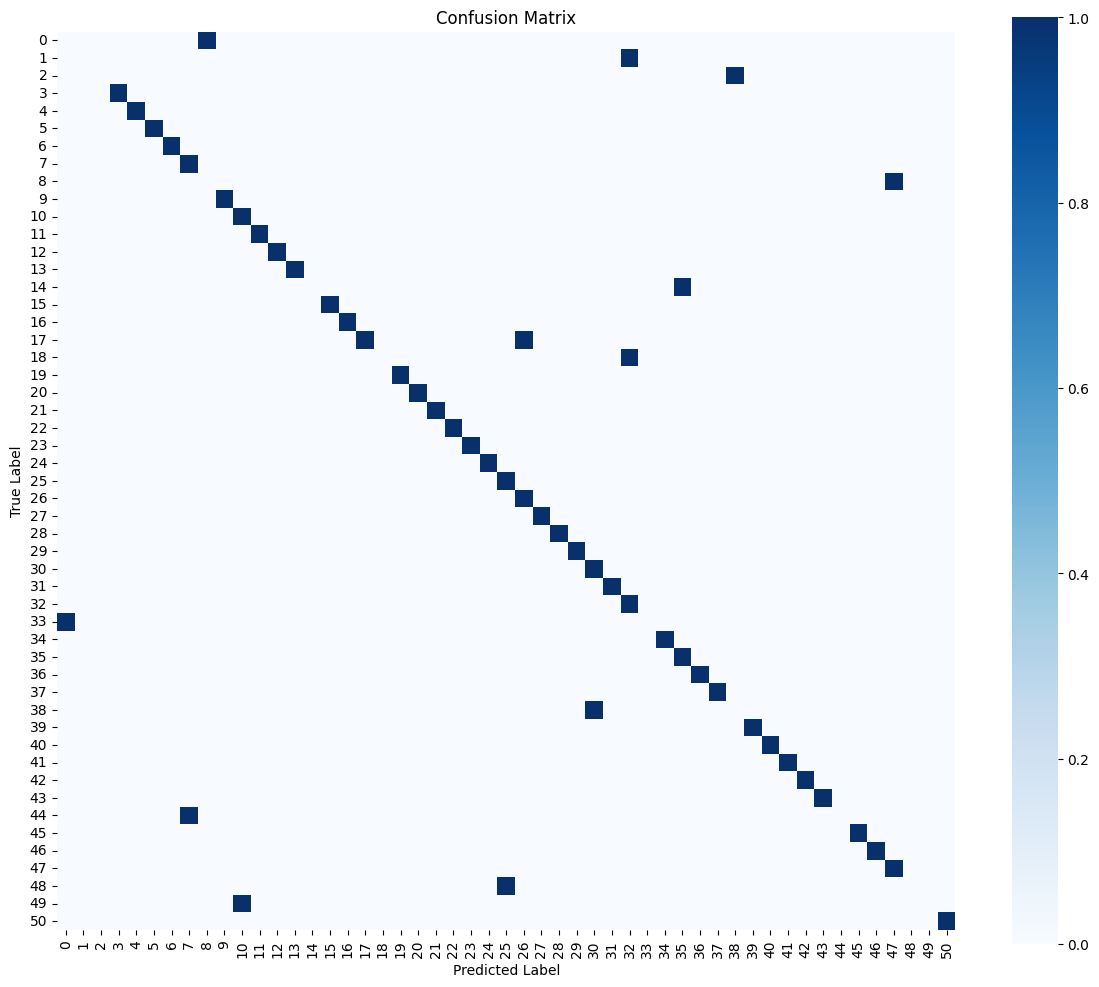

In [ ]:
# ----------------------------
#  Confusion Matrix
# ----------------------------
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", fmt='d', square=True, cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------
#  Summary of Metrics
# ----------------------------
print("\n=== Evaluation Summary ===")
print(f"Accuracy       : {accuracy * 100:.2f}%")
print(f"Precision (macro avg): {precision:.4f}")
print(f"Recall (macro avg)   : {recall:.4f}")
print(f"F1 Score (macro avg) : {f1:.4f}")


=== Evaluation Summary ===
Accuracy       : 76.92%
Precision (macro avg): 0.7026
Recall (macro avg)   : 0.7745
F1 Score (macro avg) : 0.7222


/tmp/ipython-input-26-1084863706.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')


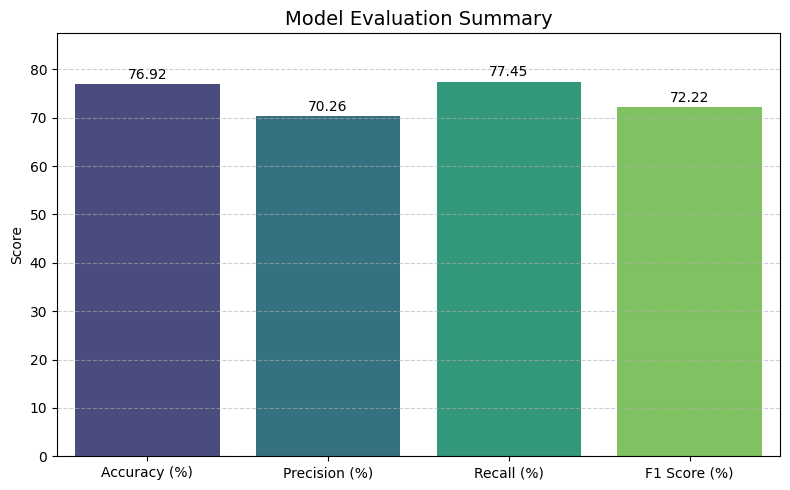

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# our computed metrics
accuracy_percent = accuracy * 100
metrics = {
    "Accuracy (%)": accuracy_percent,
    "Precision (%)": precision * 100,
    "Recall (%)": recall * 100,
    "F1 Score (%)": f1 * 100
}

# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')

# Annotate bars with values
for i, (key, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.5, f"{value:.2f}", ha='center', va='bottom', fontsize=10)

plt.title("Model Evaluation Summary", fontsize=14)
plt.ylabel("Score")
plt.ylim(0, max(metrics.values()) + 10)  # Add margin for accuracy which is in percent
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()